# Best Result - Random Forest Classifier - 87% Accuracy
The random Forest classifier aachieved an impressive result of 87% and the following are a list of steps that were carried out to achieve this result
1. Cleaning of the dataset including the removal of missing data points and turning cateogtical data into numerical data.
2. Feature Selection -  Removal of features that are not required.
3. Feature Engineering - The creation of a new 'Duration' feature to replace the 'CallStart' and 'CallEnd' features.
4. Feature Scaling - Put all features into a similar range through Mix-Max Normalization. 
5. Random Over-Sampling to deal with the imbalance in the positive and negative training cases. 
6. K-Fold Cross Validation Testing to get accurate results.
7. Hyperparameter Tuning using Grid-Search.
8. Model Analysis using ROC curves, AUROC score, Confusion Matrices, Precision, Recall and F1-Scores.

It is also worth noting that while the Random Forest gives a higher accuracy, the cost of getting a sample wrong and making a phone call to a person who would not but the insurance is much less than the cost of not calling a person who would but the insurance. Therefore I believe it is much more important to increase True Positives and decrease False Negatives and therefore the Boosting algorithm, with a lower accuracy, is actually the better algorithm. Essentially we are aiming to maximise Recall in the positive class.

The unit tests for the REST API are located at the bottom of this notebook.

In [68]:
#Bring in all the imports we will use 
import pickle as p 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pandas as pd 
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn import svm, metrics
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, GridSearchCV
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
#Remove the warnings that are gotten while doing K-Fold Cross Validation
import warnings
warnings.filterwarnings('ignore')

In [38]:
#Read the training and test files
train_df = pd.read_csv('C:/Users/lhaye/Documents/Genesys_Task_Dataset/carInsurance_train.csv')
test_df = pd.read_csv('C:/Users/lhaye/Documents/Genesys_Task_Dataset/carInsurance_test.csv')


#LETS PUT THE COLUMNS INTO A LIST SO WE CAN SEE WHICH ONES CORRESPOND TO FEATURES AND WHICH TO 
columns = train_df.columns.tolist()
feature_columns = columns[:-1]
output_column = columns[-1:]
num_train_samples = train_df.shape[0]
print("We number of training samples we have is : ", num_train_samples)
print("The number of features we have is : ", )

# Data Analysis

In [48]:
print(train_df.shape)

(4000, 20)


In [49]:
#Check for cateorical features (Will have to change these to numeric values)
print(train_df.info)

<bound method DataFrame.info of         Id  Age   Job  Marital  Education  Default  Balance  HHInsurance  \
0        1   32   5.0      2.0        3.0        0     1218            1   
1        2   32   2.0      1.0        1.0        0     1156            1   
2        3   29   5.0      2.0        3.0        0      637            1   
3        4   25   9.0      2.0        1.0        0      373            1   
4        5   30   5.0      1.0        3.0        0     2694            0   
...    ...  ...   ...      ...        ...      ...      ...          ...   
3995  3996   28  10.0      2.0        3.0        0        0            1   
3996  3997   49   1.0      0.0        2.0        0      124            1   
3997  3998   27   1.0      2.0        2.0        0     -400            0   
3998  3999   36   3.0      2.0        3.0        0      658            1   
3999  4000   45   8.0      1.0        1.0        0      137            1   

      CarLoan  Communication  LastContactDay LastContac

In [50]:
#Check the data types and we can see that the object type represents a categorical feature which we will have to change
print(train_df.dtypes)

Id                    int64
Age                   int64
Job                 float64
Marital             float64
Education           float64
Default               int64
Balance               int64
HHInsurance           int64
CarLoan               int64
Communication       float64
LastContactDay        int64
LastContactMonth     object
NoOfContacts          int64
DaysPassed            int64
PrevAttempts          int64
Outcome             float64
CallStart             int64
CallEnd               int64
CarInsurance          int64
CallDuration          int64
dtype: object


In [52]:
#Look for any missing data samples
print(train_df.isnull().sum())

Id                  0
Age                 0
Job                 0
Marital             0
Education           0
Default             0
Balance             0
HHInsurance         0
CarLoan             0
Communication       0
LastContactDay      0
LastContactMonth    0
NoOfContacts        0
DaysPassed          0
PrevAttempts        0
Outcome             0
CallStart           0
CallEnd             0
CarInsurance        0
CallDuration        0
dtype: int64


# Feature Visualization (Not enough time to carry out but ideas are explained)
Ideally here we would do some analysis on the features to see how their values effect whether they decide to but the car insurance or not. For example I believe that the call duration feeature I have created is a feature that is likely to have a big output on the prediction. For each length of the call i.e. each minute, we could plot the split for how many customers whos call ended on that minute decided to buy/not buy the car insurance. I believe we would see the number that didn't buy being very high at the beginning and then this number would reduve while the number that would buy would increase. We could carry out such an analysis on mostly all of the features. Another important feature to analyse to me would be bank balance as I can imagine that as the bank balance goes up, people are more likely to purchase the insurance. We could carry this analysis out accross all the features and this would then give an idea as to what the important features are. 

# Data Preprocessing
Here we carry out some preprocessing steps on the data in order to put it into the format that will result in the best results. The following steps were carried out:
1. Removal of any missing data samples. These are denoted by Na or Nan. These are not usable in a machine learning algorithm and must be filtered out. In this eaxmple however, these occur in the categorical features meaning that the data can simply be given its own category if it is not available. Sometimes the data may be missing and in other cases it is not applicable.

2. Check if there are any duplicate samples and we can see that in our case there are none. 

3. Change the categorical features to numeric. Machine learning algorithms deal with numbers and not strings so what we do here is assign each category a number. 

4. Check for outliers. I did some analysis to try and remove these but if we were to do so in this case there would be a huge number of samples missing. Outliers can have a big influence on the machine learning algorithms accuracy. I could have assigned bins in order to scale these down for example if x is less than 5000 and greater than 2500 give it a value of 2. I have decided to just apply Min-Max Normalization. This assigns the lowest value of the feature to 0 and then the maximum to 1 and every other value inbetween is scaled accordingly.

5. Feature Scaling - As I just explained I carried out Min-Max Normalization to put all the features in the same range as not doing so can affect the accuracy of the algorithm.

6. Feature Engineering - Created a 'Duration' feature to utilize two features that give very little information. This may help to increse accuracy as one could imagine that the longer a phone call was the more willing a customer would be to purchase a product. 

7. Removal of features that are not required. Some features are not independent and thus should be removed. 

In [39]:
#Lets get the preprocessed data and then make alterations to it based on the model score 
def preprocess_data(data):
 
    #Check for duplicate data
    duplicate_rows_df = data[data.duplicated()]
    print('number of duplicate rows: ', duplicate_rows_df.shape)
    
    #Modify all data that is Na with a word to avoid difficulties 
    data['Education'] = data['Education'].fillna("NoVal")
    data['Job'] = data['Job'].fillna("NoVal")
    data['Communication'] = data['Communication'].fillna("NoVal")
    data['Outcome'] = data['Outcome'].fillna("NoVal")

    #We tranlsate the categorical labels into numeric labels 
    ord_enc = OrdinalEncoder()
    data["Education"] = ord_enc.fit_transform(data[["Education"]])
    data["Marital"] = ord_enc.fit_transform(data[["Marital"]])
    data["Job"] = ord_enc.fit_transform(data[["Job"]])
    data["Outcome"] = ord_enc.fit_transform(data[["Outcome"]])
    data["Communication"] = ord_enc.fit_transform(data[["Communication"]])
    
    #Create a feature for the duration of the call 
    data['CallStart'] = pd.to_datetime(data["CallStart"])
    data['CallEnd'] = pd.to_datetime(data["CallEnd"])
    data['CallStart'] = (data['CallStart'].dt.hour*60+data['CallStart'].dt.minute)*60 + data['CallStart'].dt.second
    data['CallEnd'] = (data['CallEnd'].dt.hour*60+data['CallEnd'].dt.minute)*60 + data['CallEnd'].dt.second
    data['CallDuration'] = data['CallEnd'] - data['CallStart']
    
    #Now we should drop some features that we dont need 
    data = data.drop(['Id', 'LastContactDay', 'LastContactMonth', 'CallStart', 'CallEnd'], axis=1)
    

    #Feature Scaling - Min-Max Normalization of all features with high values 
    #Put them all in the same range 
    data['Balance'] = (data['Balance'] - data['Balance'].min()) / (data['Balance'].max() - data['Balance'].min())
    data['NoOfContacts'] = (data['NoOfContacts'] - data['NoOfContacts'].min()) / (data['NoOfContacts'].max() - data['NoOfContacts'].min())
    data['Age'] = (data['Age'] - data['Age'].min()) / (data['Age'].max() - data['Age'].min())
    data['DaysPassed'] = (data['DaysPassed'] - data['DaysPassed'].min()) / (data['DaysPassed'].max() - data['DaysPassed'].min())
    data['PrevAttempts'] = (data['PrevAttempts'] - data['PrevAttempts'].min()) / (data['PrevAttempts'].max() - data['PrevAttempts'].min())
    data['CallDuration'] = (data['CallDuration'] - data['CallDuration'].min()) / (data['CallDuration'].max() - data['CallDuration'].min())
    data['Job'] = (data['Job'] - data['Job'].min()) / (data['Job'].max() - data['Job'].min())
    data['Education'] = (data['Education'] - data['Education'].min()) / (data['Education'].max() - data['Education'].min())
    data['Marital'] = (data['Marital'] - data['Marital'].min()) / (data['Marital'].max() - data['Marital'].min())
    data['Communication'] = (data['Communication'] - data['Communication'].min()) / (data['Communication'].max() - data['Communication'].min())
    
    return data

In [40]:
#Take the training data and preprocess using the process outlined earlier
x_train_processed = preprocess_data(train_df)
#get the columns for the features into one list and the actual labels into another 
y_train_vals = train_df[output_column]
x_train_processed = x_train_processed.drop(labels='CarInsurance', axis=1)

In [41]:
#Split the data into a training and test set 
X_train, X_test, y_train, y_test = train_test_split(x_train_processed, y_train_vals, test_size=0.2, random_state=42)
y_test = y_test['CarInsurance']

# Test for an Imbalance in the training dataset 
As we can see from the result below, this dataset is imbalanced as there are many more negative samples than positive. 

In [42]:
zeros = y_train.loc[y_train['CarInsurance'] == 0]
ones = y_train.loc[y_train['CarInsurance'] == 1]

print(len(zeros))
print(len(ones))

1912
1288


# Handling Imbalanced Data 
I will try two approached here each of which has their strenghts and weaknesses:

1. Random Under-Sampling
2. Random Over-Sampling


In [43]:
#Oversample the minority class
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train, y_train)

#undersample the majority class
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X_train, y_train)

# K-Fold Cross Validation 
Here I have utilisex K-Fold Cross Validations as a means of testing which algorithm performs the best. This method involves splitting the data into several different folds or groups that will each be different from eachother. Each model will then be trained and tested on the same fold and I have selected to do this 10 times. This is done randomly and thus is a much better means of evaluating performance rather than just evaluating on one train-test split of the data. Doing so will not give a fair evaluation of the results.

In [44]:
#Now lets run using k-fold cross validation to get the best 
#We will run them with some standard parameters just to get an idea of the best 3 and then do some further analysis on those
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scoring = ['accuracy']

models = [
          ('Logistic Regression', LogisticRegression()), 
          ('Support Vector Machine Linear', svm.SVC(kernel='linear', gamma='auto')),
          ('Support Vector Machine Rbf', svm.SVC(kernel='rbf', gamma='auto')),
          ('Support Vector Machine NuSVC', svm.NuSVC(gamma='auto')), 
          ('Random Forest', RandomForestClassifier(n_estimators = 100, random_state=1)),
          ('Decision Tree', DecisionTreeClassifier(max_depth=1)),
          ('K-Nearest Neighbours', KNeighborsClassifier(n_neighbors=5)), 
          ('Linear Discriminant Analysis', LinearDiscriminantAnalysis()),
          ('Naive Bayes', MultinomialNB()),
          ('Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=1)), 
          ('Ensemble', VotingClassifier(estimators=[('boost', GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=1)), ('SVM', svm.NuSVC(gamma='auto')) , ('rf', RandomForestClassifier(n_estimators = 100, random_state=1))], voting = 'hard'))
        ]

for name, model in models:

    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
    cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    avg_accuracy = np.mean(cv_results['test_accuracy']) * 100 
    print(f"The {name} achieves a mean accuracy result of {avg_accuracy} over a 10-fold validation set")
    

The Logistic Regression achieves a mean accuracy result of 79.59375 over a 10-fold validation set
The Support Vector Machine Linear achieves a mean accuracy result of 80.09375000000001 over a 10-fold validation set
The Support Vector Machine Rbf achieves a mean accuracy result of 77.18749999999999 over a 10-fold validation set
The Support Vector Machine NuSVC achieves a mean accuracy result of 80.40625 over a 10-fold validation set
The Random Forest achieves a mean accuracy result of 81.9375 over a 10-fold validation set
The Decision Tree achieves a mean accuracy result of 73.625 over a 10-fold validation set
The K-Nearest Neighbours achieves a mean accuracy result of 74.62500000000001 over a 10-fold validation set
The Linear Discriminant Analysis achieves a mean accuracy result of 79.03125 over a 10-fold validation set
The Naive Bayes achieves a mean accuracy result of 65.40625 over a 10-fold validation set
The Boosting achieves a mean accuracy result of 82.0625 over a 10-fold validat

# Random Under-Sampling and Random Over-Sampling Results
As we can see below the under-sampling approach led to little or no improvement which over-sampling actually led to quite an impressive increase in performance in some of the algorithm. This can be especially be seen in the Random Forest model which previously had been the best performing algorithm. Over-Sampling led to an icnrease of almost 5% in accuracy which is a significant gain for such a simple approach. This approach is therefore highly valuable because the otehr solution would be to gather more data which as we know is a costly process. This means that from this point onwards we will train the models on the Over-Sampled datasets.

In [45]:
#Here we are going to test the over and under sampling methods to see if they helped the accuracy 
results = {}

print("Over-Sampling Results")
for name, model in models:

    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
    cv_results = model_selection.cross_validate(model, X_over, y_over, cv=kfold, scoring=scoring)
    avg_accuracy = np.mean(cv_results['test_accuracy']) * 100 
    print(f"The {name} achieves a mean accuracy result of {avg_accuracy} over a 10-fold validation set")
    results[name] = avg_accuracy

print()
print()

print("Under-Sampling Results")
for name, model in models:

    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
    cv_results = model_selection.cross_validate(model, X_under, y_under, cv=kfold, scoring=scoring)
    avg_accuracy = np.mean(cv_results['test_accuracy']) * 100 
    print(f"The {name} achieves a mean accuracy result of {avg_accuracy} over a 10-fold validation set")


Over-Sampling Results
The Logistic Regression achieves a mean accuracy result of 79.44383688980629 over a 10-fold validation set
The Support Vector Machine Linear achieves a mean accuracy result of 79.80991893702239 over a 10-fold validation set
The Support Vector Machine Rbf achieves a mean accuracy result of 79.234959605211 over a 10-fold validation set
The Support Vector Machine NuSVC achieves a mean accuracy result of 81.61421951252854 over a 10-fold validation set
The Random Forest achieves a mean accuracy result of 87.00285702568588 over a 10-fold validation set
The Decision Tree achieves a mean accuracy result of 72.51466105286181 over a 10-fold validation set
The K-Nearest Neighbours achieves a mean accuracy result of 76.22865774472682 over a 10-fold validation set
The Linear Discriminant Analysis achieves a mean accuracy result of 79.18226183478463 over a 10-fold validation set
The Naive Bayes achieves a mean accuracy result of 62.786283542711864 over a 10-fold validation set


In [46]:
top_3_models = sorted(results, key=results.get, reverse=True)[:3]

for i in range(len(top_3_models)):
    if(i == 0):
        print("The models with the top 3 results are: ")
        print("-", top_3_models[i])
    else:
        print("-", top_3_models[i])

The models with the top 3 results are: 
- Random Forest
- Ensemble
- Boosting


# Hyperparameter Tuning using Grid-Search

Here I have carried out grid-search for each of the three top performing algorithms. Grid-search involves testing all combinations of the chosen hyperparameters and is a very effective means of exhaustively testing the chosen combinations fo the hyperparameters in an aim to get the best combination. This is an NP hard problem however and grows exponentially in time complexity as more parameters are added.

In [56]:
#Now lets take the top 3 and get the best parameters using grid search and then do some analysis of the scores of them
#('Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=1)), 
#('Random Forest', RandomForestClassifier(n_estimators = 100, random_state=1)),
#('Support Vector Machine NuSVC', svm.NuSVC(gamma='auto')), 

RFModel = RandomForestClassifier(random_state=1)

#By doing this grid search we are essentially searching for the parameters that reduce overfitting the most

param_grid  = { 
    #Number of trees to create 
    #The more this is the less likely overfitting is as it becomes less and less like a decision tree 
    'n_estimators': [40, 60, 80, 100, 200],
    #How many features we consider per tree as a starting point 
    #The lower this is the less likely overfitting is 
    'max_features': ['auto', 'sqrt', 'log2'],
    #How large is the trees max depth 
    'max_depth' : [2,5,6,7,8,9,10, None],
    #Which impurity measure to use in the split
    'criterion' :['gini', 'entropy']
}

GS_RF = GridSearchCV(estimator=RFModel, param_grid=param_grid, cv= 5)
GS_RF.fit(X_over, y_over)
print(GS_RF.best_params_)


#Grid search for Boosting 
BoostingModel = GradientBoostingClassifier(random_state=1)

param_grid  = { 
    #Number of boosting stages to carry out 
    'n_estimators': [100, 200, 400, 500, 800],
    #How many features we consider per tree as a starting point 
    'learning_rate': [0.001, 0.005, 0.01, 0.1, 0.5],
    #How large is the trees max depth 
    'max_depth' : [3,4,5,7,9],
    #Which impurity measure to use in the split
    'max_features': ['auto', 'sqrt', 'log2'],
}

GSBoosting = GridSearchCV(estimator=BoostingModel, param_grid=param_grid, cv= 5)
GSBoosting.fit(X_over, y_over)
print(GSBoosting.best_params_)


SVMModel = svm.NuSVC()

param_grid = {'nu': [0.1, 0.3, 0.5, 0.7, 0.9], 
              'gamma': ['scale', 'auto'],
              'kernel': ['linear', 'poly', 'rbf']}

GS_SVM = GridSearchCV(estimator=SVMModel, param_grid=param_grid, cv= 5)
GS_SVM.fit(X_over, y_over)
print(GS_SVM.best_params_)


{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 40}


# Improvement in Results Post Grid-Search

In [63]:
#Best parameters for the Random Forest Model
#{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 40}
RFModel = RandomForestClassifier(criterion= 'gini', max_depth= None, max_features= 'auto', n_estimators= 40, random_state=1)

#Best parameters for the Boosting Model
#{'learning_rate': 0.01, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500}
BoostingModel = GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features='sqrt', n_estimators=500, random_state=1)

#Best parameters for the SVM Model 
#{'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.5}
SVMModel = svm.NuSVC(gamma = 'auto', kernel = 'rbf', nu = 0.5)

#Ensemble model combines all 3 
Ensemble = VotingClassifier(estimators=[('boost', BoostingModel), ('SVM', SVMModel) , ('rf', RFModel)], voting = 'hard')

models = [
          ('Random Forest Model', RFModel),
          ('Support Vector Machine NuSVC', SVMModel), 
          ('Boosting', BoostingModel), 
          ('An Ensemble', Ensemble)
        ]

for name, model in models:

    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
    cv_results = model_selection.cross_validate(model, X_over, y_over, cv=kfold, scoring=scoring)
    avg_accuracy = np.mean(cv_results['test_accuracy']) * 100 
    print(f"The {name} achieves a mean accuracy result of {avg_accuracy} over a 10-fold validation set")

The Random Forest Model achieves a mean accuracy result of 87.05534974642187 over a 10-fold validation set
The Support Vector Machine NuSVC achieves a mean accuracy result of 81.61421951252854 over a 10-fold validation set
The Boosting achieves a mean accuracy result of 84.12573647013792 over a 10-fold validation set
The An Ensemble achieves a mean accuracy result of 84.59577871037416 over a 10-fold validation set


# Model Evaluation
As I explained at the top of this file, we are aiming to maximise the number of true positives and essentially minimise false negatives. I believe there is less of a cost to misclassifying some samples where the caller would not buy the insurance and therefore I believe that when working with models of similar overall accuracy the recall of the positive case becomes more important than the overall accuracy. This is especially compounded by the fact this dataset is imbalanced and therefore it is better at classifying the negative samples. As we can see from the metrics below the Boosting algorithm has the best Recall score for the positive class. 

In [71]:
#This will give the Precision, Recall and the F1 score
print("Results for the Boosting Model: ")
BoostingModel.fit(X_over, y_over)
Boosting_predictions = BoostingModel.predict(X_test)
BoostingReport = classification_report(y_test, Boosting_predictions)
print(BoostingReport)

print()
print()

print("Results for the Ensemble Model: ")

Ensemble.fit(X_over, y_over)
Ensemble_predictions = Ensemble.predict(X_test)
EnsembleReport = classification_report(y_test, Ensemble_predictions)
print(EnsembleReport)

print()
print()

print("Results for the Random Forest Model: ")
RFModel.fit(X_over, y_over)
RFModel_predictions = RFModel.predict(X_test)
RFModelReport = classification_report(y_test, RFModel_predictions)
print(RFModelReport)

print()
print()

print("Results for the SVM Model: ")
SVMModel.fit(X_over, y_over)
SVM_predictions = SVMModel.predict(X_test)
SVMReport = classification_report(y_test, SVM_predictions)
print(SVMReport)



Results for the Boosting Model: 
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       484
           1       0.75      0.83      0.79       316

    accuracy                           0.82       800
   macro avg       0.82      0.83      0.82       800
weighted avg       0.83      0.82      0.83       800



Results for the Ensemble Model: 
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       484
           1       0.76      0.82      0.79       316

    accuracy                           0.82       800
   macro avg       0.82      0.82      0.82       800
weighted avg       0.83      0.82      0.83       800



Results for the Random Forest Model: 
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       484
           1       0.77      0.81      0.79       316

    accuracy                           0.83       800
   macro avg       0

# Confusion Matrix Evalution
When looking at this problem where we are aiming to correctly classify whether a person will be a good candidate to cold call I believe that a successful algorithm should be aiming to have as high of an accuracy as possible. However, I also believe it is essential to have True Positives as high as possible as these are the people who will in fact buy the insurance. Therefore, we are aiming to reduce the False Negative number while increasing the True Positive number to be as high as possible. If we take this into consideration then actually the Boosting model has the best results. The reason I believe that this is true is because there is a big benefit in getting as many people correct that would buy the insurance wheras the cost to calling a person who has no interest will typically lead to a short call and therefore very little time wasted. Thus I believe that getting as many True Positives is essential. 

Boosting Model Confusion Matrix:


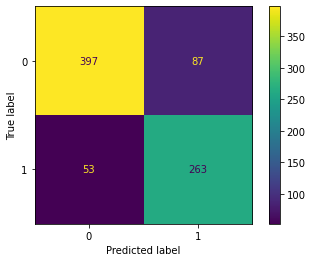



Ensemble Model Confusion Matrix:


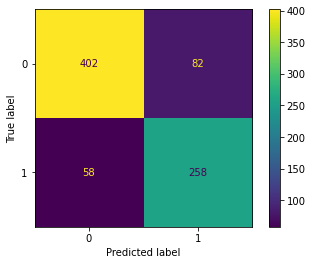



Random Forest Model Confusion Matrix:


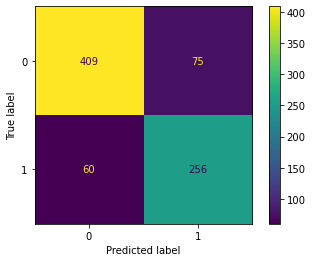



SVM Model Confusion Matrix:


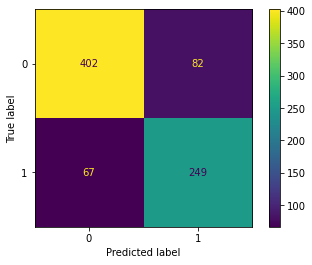

In [70]:
#This will give us a confusion martrix with True Positive, True Negative, False Positive and False Negatives

print("Boosting Model Confusion Matrix:")
plot_confusion_matrix(BoostingModel, X_test, y_test)  
plt.show()

print()
print()

print("Ensemble Model Confusion Matrix:")
plot_confusion_matrix(Ensemble, X_test, y_test)  
plt.show()

print()
print()

print("Random Forest Model Confusion Matrix:")
plot_confusion_matrix(RFModel, X_test, y_test)  
plt.show()

print()
print()

print("SVM Model Confusion Matrix:")
plot_confusion_matrix(SVMModel, X_test, y_test)  
plt.show()


In [27]:
#Save the models that we will use in the REST API
p.dump(RFModel, open('RandomForest.pickle', 'wb'))
p.dump(BoostingModel, open('BoostingModel.pickle', 'wb'))

# ROC Curve and Area Under ROC Curve Evaluation
The ROC curve illustrates the trade-off between the True Positive Rate (TPR) and the False Positive Rate (FPR). It essentially looks at how these change as we alter the classification threshold. It essentially highlights the relationship between the TPR and the FPR and essentially shows how an improvement in one affects the other. In some applications False Negatives are detrimental such as detecting cancer so extra emphasis will be put in place to reduce these while allowing for increased False Positives. In this scenario I believe that extra emphasis should be places as in detecting cancer on minimising False Negatives. These ROC curves and thus the Area Under the ROC curves that we obtain from these algorithms are both very similar and very good. They tell us we can achieve a good TPR rate without increasing the FPR too much. Again recall that the most imporant thing here is the TPR as we are trying to maximise this ratio as it is Recall which I have highlighted to be of high importance in earlier evaluation. 

In [28]:
#This will give the Area Under the ROC Curve
scoring = 'roc_auc'
results = model_selection.cross_val_score(BoostingModel, X_test, y_test, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

results = model_selection.cross_val_score(RFModel, X_test, y_test, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

results = model_selection.cross_val_score(SVMModel, X_test, y_test, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.889 (0.040)
AUC: 0.888 (0.038)
AUC: 0.888 (0.037)


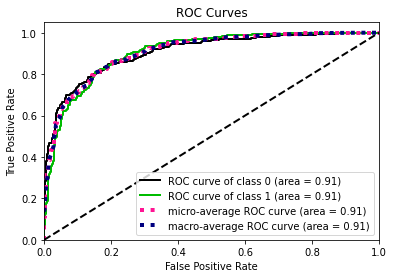

In [29]:
#ROC Curve for the Boosting Model
y_preds = BoostingModel.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_preds)
plt.show()

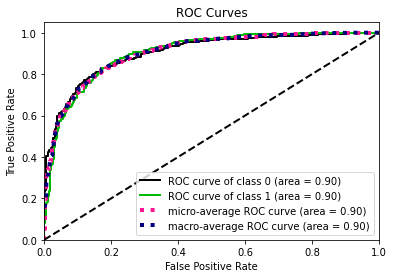

In [30]:
#ROC Curve for the Random Forest Model
y_preds = RFModel.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_preds)
plt.show()

In [53]:
#Do some preprocessing on the test data
x_test_processed = preprocess_data(test_df)
x_test_processed = x_test_processed.drop(labels='CarInsurance', axis=1)
y_test_vals = test_df[output_column]

# REST API Unit Testing

Here I have included some unit tests to test the functionality of the REST API. It is worth noting that if this were to be for a production system the testing would have to be much more rigerous and many more test would be included. 

In [75]:
#and here will be the client 
import requests
import json
import unittest

#This is to test the predictions of new samples
def test_predictions():

    url = 'http://127.0.0.1:1080/algorithm' 

    #Test a sample that is predicted as a 0
    new = x_test_processed.iloc[0].to_json(orient='split')

    response = requests.post(url, json=new)
    expected_res = {'Prediction': 0}
    assert response.json() == expected_res, "Should have returned a 0"


    #Test a sample that is predicted as a 1
    new = x_test_processed.iloc[7].to_json(orient='split')

    response = requests.post(url, json=new)
    expected_res = {'Prediction': 1}
    assert response.json() == expected_res, "Should have returned a 1"



#This is to test the predictions of new samples
def test_retraining():

    url = 'http://127.0.0.1:1080/retrain' 

    X_train['CarInsurance'] = y_train 
    comb_df = X_train

    new = comb_df.to_json(orient='split')

    response = requests.post(url, json=new)
    expected_res = 200
    assert response.json() == expected_res, "Should have seen a return code of 200"


#This is to test the changing of the model
def test_modelChange():

    #Now we want to change the model 
    url = 'http://127.0.0.1:1080/change_model' 

    new_model = {"model":"BoostingModel.pickle"}

    model_json = json.dumps(new_model)

    response = requests.post(url, json=model_json)
    expected_res = 200

    assert response.json() == expected_res, "Should have seen a return code of 200"


#This is to test the method to get the model we are using 
def test_modelName():
    
    #Now we want to check which model is in use  
    #As we can see this method can be used to unit test the functionality of changing the model 
    url = 'http://127.0.0.1:1080/algorithm'  

    response = requests.get(url)
    expected_res = "GradientBoostingClassifier"

    assert response.json() == expected_res, "Should have seen a return code of 200"


#This is to test the retrieving all the data from the database
def test_dataRetrieval(empty_test):
    
    #Now we will check that we can retrive all of the database samples
    url = 'http://127.0.0.1:1080/database'  
    
    if (empty_test == False):
        response = requests.get(url)

        assert len(response.json()) >= 1, "Should have seen a return code of 200"
    else:
        response = requests.get(url)
        expected_res = "The database is empty"

        assert response.json() == expected_res, "Should see a database empty error"      

#This is to test updating the database sample at a specified index with new data 
def test_dataUpdate():
    
    url = 'http://127.0.0.1:1080/database'  

    index = 0
    data = x_test_processed.iloc[0, :]

    data['index'] = index

    model_json = data.to_json(orient = 'columns')
    expected_res = 200

    response = requests.put(url, json=model_json)
    assert response.json() == expected_res, "Should have seen a return code of 200"
    
    index = 50
    data = x_test_processed.iloc[0, :]

    data['index'] = index

    model_json = data.to_json(orient = 'columns')
    expected_res = "Error - The sample index supplied is not in the database"

    response = requests.put(url, json=model_json)
    assert response.json() == expected_res, "Should have seen an error code as the index is too big"


#This is a test to see if the data entry at a specified index is deleted correctly
def test_deletion():

    #Now we test to make sure we can delete records from the database 
    url = 'http://127.0.0.1:1080/database'  

    #Test an example where we can delete the data
    index = "0"
    model_json = json.dumps(0)
    expected_res = 200
    response = requests.delete(url, json=model_json)
    assert response.json() == expected_res, "Should have seen a return code of 200"

    #Test one that is out of bounds so we are testing the error detection
    index = "50"
    model_json = json.dumps(0)
    response = requests.delete(url, json=model_json)    
    expected_res = "Error - The sample index supplied is not in the database"
    assert response.json() == expected_res, "Should have seen an error code to say index is not in database"

In [78]:
if __name__ == "__main__":
    test_dataRetrieval(True)
    test_predictions()
    test_retraining()
    test_modelChange()
    test_modelChange()
    test_dataRetrieval(False)
    test_dataUpdate()
    
    print("Everything passed")
    


Everything passed
